# Retina Analysis
This notebook contain the analysis for IoU for the retina model output. This goes into details on the analysis of missing instances for the model.

In [10]:
import os
import numpy as np
from collections import defaultdict
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import xml.etree.ElementTree as ET

In [11]:
import os
import numpy as np
from collections import defaultdict
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def read_yolo_annotations(txt_path):
    """Read YOLO-format annotations from a .txt file."""
    annotations = []
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as f:
            for line in f.readlines():
                parts = list(map(float, line.strip().split()))
                if len(parts) >= 6:
                    annotations.append({
                        'class': int(parts[0]),
                        'bbox': parts[1:5],  # x_center, y_center, w, h
                        'confidence': parts[5]
                    })
    return annotations

def calculate_iou(box1, box2):
    """Compute IoU between two normalized YOLO boxes."""
    def to_corners(box):
        x_center, y_center, w, h = box
        x1 = x_center - w/2
        y1 = y_center - h/2
        x2 = x_center + w/2
        y2 = y_center + h/2
        return [x1, y1, x2, y2]
    
    box1 = to_corners(box1)
    box2 = to_corners(box2)
    
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    
    return inter_area / (box1_area + box2_area - inter_area + 1e-6)

def evaluate_detection(gt_folder, pred_folder, iou_thresh=0.5):
    """Full evaluation accounting for false negatives"""
    
    # ===================================================================
    # 1. Collect all ground truths and predictions globally
    # ===================================================================
    all_preds = []
    gt_db = defaultdict(list)
    total_gts = 0

    # Read all ground truths
    for gt_file in os.listdir(gt_folder):
        if not gt_file.endswith(".txt"): continue
        base_name = os.path.splitext(gt_file)[0]
        gt_path = os.path.join(gt_folder, gt_file)
        gts = read_yolo_annotations(gt_path)
        gt_db[base_name] = gts
        total_gts += len(gts)

    # Read all predictions and store with image ID
    for pred_file in os.listdir(pred_folder):
        if not pred_file.endswith(".txt"): continue
        base_name = os.path.splitext(pred_file)[0]
        pred_path = os.path.join(pred_folder, pred_file)
        preds = read_yolo_annotations(pred_path)
        
        for pred in preds:
            all_preds.append({
                'image_id': base_name,
                'confidence': pred['confidence'],
                'bbox': pred['bbox']
            })

    # ===================================================================
    # 2. Sort predictions by confidence (global sorting)
    # ===================================================================
    all_preds.sort(key=lambda x: -x['confidence'])

    # ===================================================================
    # 3. Process predictions in confidence order
    # ===================================================================
    matched_gts = defaultdict(set)  # Track matched GT indices per image
    tp_list = []
    fp_list = []
    
    for pred in all_preds:
        image_id = pred['image_id']
        pred_bbox = pred['bbox']
        max_iou = 0.0
        match_idx = -1

        # Find best unmatched GT in this image
        for idx, gt in enumerate(gt_db.get(image_id, [])):
            if idx in matched_gts[image_id]: continue  # Skip already matched
            iou = calculate_iou(pred_bbox, gt['bbox'])
            if iou > max_iou:
                max_iou = iou
                match_idx = idx

        # Determine TP/FP
        if max_iou >= iou_thresh:
            matched_gts[image_id].add(match_idx)
            tp_list.append(1)
            fp_list.append(0)
        else:
            tp_list.append(0)
            fp_list.append(1)

    # ===================================================================
    # 4. Calculate final metrics
    # ===================================================================
    tp = np.cumsum(tp_list)
    fp = np.cumsum(fp_list)
    fn = total_gts - tp
    
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (total_gts + 1e-10)
    
    return {
        'precision': precision,
        'recall': recall,
        'AP': average_precision_score(tp_list, [p['confidence'] for p in all_preds]),
        'total_gts': total_gts,
        'total_preds': len(all_preds),
        'tp': tp[-1] if len(tp) > 0 else 0,
        'fp': fp[-1] if len(fp) > 0 else 0,
        'fn': fn[-1] if len(fn) > 0 else total_gts,
        "matched_gt": matched_gts
    }

# ===================================================================
# 5. Visualization and Reporting
# ===================================================================
def plot_metrics(results, iou_thresh=0.5):
    plt.figure(figsize=(12, 5))
    
    # Precision-Recall Curve
    plt.subplot(121)
    plt.plot(results['recall'], results['precision'], label=f'AP={results["AP"]:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve @ IoU={iou_thresh}')
    plt.grid(True)
    plt.legend()

    # Metrics Summary
    plt.subplot(122)
    metrics = [
        ('True Positives', results['tp']),
        ('False Positives', results['fp']),
        ('False Negatives', results['fn']),
        ('Total GT', results['total_gts']),
        ('Total Pred', results['total_preds'])
    ]
    plt.barh([m[0] for m in metrics], [m[1] for m in metrics])
    plt.title('Detection Breakdown')
    plt.tight_layout()
    plt.show()


In [ ]:
# Folder A (ground truth annotations) with Folder B (model predictions)
# Run evaluation
# groundTruth = "../sesame/ssic_image-corpus/data_phase-4_consensus/face/label_face_only_actual_yolo"

groundTruth = "../sesame/ssic_image-corpus/data_phase-4_consensus/face/label_face_only_actual_yolo"

modelPrediction = "../sesame/ssic_image-corpus/data_phase-4_consensus/face/retinaface_output_toyolo"


results = evaluate_detection(groundTruth, modelPrediction, iou_thresh=0.5)

In [ ]:
    # return {
    #     'precision': precision,
    #     'recall': recall,
    #     'AP': average_precision_score(tp_list, [p['confidence'] for p in all_preds]),
    #     'total_gts': total_gts,
    #     'total_preds': len(all_preds),
    #     'tp': tp[-1] if len(tp) > 0 else 0,
    #     'fp': fp[-1] if len(fp) > 0 else 0,
    #     'fn': fn[-1] if len(fn) > 0 else total_gts,
    #     "matched_gt": matched_gts
    # }

with open("../sesame/ssic_image-corpus/scripts/benchmark/retina_results_analysis_length.txt", "w") as f:

        f.write(f"AP: {results['AP']:.3f}\n")
        f.write(f"Total GTs: {results['total_gts']}\n")
        f.write(f"Total Predictions: {results['total_preds']}\n")
        f.write(f"True Positives: {results['tp']}\n")
        f.write(f"False Positives: {results['fp']}\n")
        f.write(f"False Negatives: {results['fn']}\n")
        f.write(f"Matched GTs: {len(results['matched_gt'])}\n")
        f.write(f"Matched GTs per image:\n")
        for image_id, matched in results['matched_gt'].items():
            f.write(f"{image_id}: {len(matched)}\n")


In [ ]:
matchedImage = results['matched_gt']

with open("../sesame/ssic_image-corpus/scripts/benchmark/only_retina_results_analysis.txt", "w") as f:
    for image_id, matched in matchedImage.items():
        f.write(f"{image_id}: {matched}\n")

# this part focuses on the analysis of the model output
`matchedImage`

In [ ]:
# go through each YOLO label file, , go through each item, keep an index of the annotation, if the index doesn't match the number, record all attribute value in dictionary

masterDict = {"species": {}, "representation": {}, "raceethnicity": {}, "age": {}, "orientation": {}, "cameraangle": {}, "visibility": {}, "clarity": {}, "rotation": {}}

groundTruth = "../sesame/ssic_image-corpus/data_phase-4_consensus/face/label_face_only_actual_labelme"

modelPrediction = "../sesame/ssic_image-corpus/data_phase-4_consensus/face/retinaface_output_toyolo"

allGroundTruth = os.listdir(groundTruth)

for x in allGroundTruth:
    if not x.endswith(".xml"): 
        continue
    base_name = os.path.splitext(x)[0]
    gt_path = os.path.join(groundTruth, x)

    # print(base_name)
    # print(gt_path)

    tree = ET.parse(gt_path)
    root = tree.getroot()
    
    position = 0

    # go through each object in the ground truth labelme file
    for obj in list(root.findall("object")):
        nameElement = obj.find("name")

        # if no element, no face annotation
        if nameElement is None:
            
            print("There is no annotation in this file")
            print(f"File: {gt_path}, Object: {obj}")

        # if not face annotation, skip - WARNING
        elif nameElement.text.strip().lower() != "face":
            print("This is not a face annotation in this file")
            print(f"File: {gt_path}, Object: {obj}")
        else:
            
            # if the position is in the matched image, then ignore
            if position in matchedImage[base_name]:
                position+= 1
                continue

            # if the position is not in the matched image, record the attribute count
            attributes_element = obj.find('attributes')
            if attributes_element is not None and attributes_element.text:
                # Parse the species value
                attributes = attributes_element.text

                speciesPart, representationPart, raceethnicityPart, agePart, orientationPart, cameraanglePart, visibilityPart, clarityPart, rotationPart = attributes.split(",")

                species = speciesPart.split("=")[-1].strip()  # Extract the species value
                representation = representationPart.split("=")[-1].strip()
                raceethnicity = raceethnicityPart.split("=")[-1].strip()
                age = agePart.split("=")[-1].strip()
                orientation = orientationPart.split("=")[-1].strip()
                cameraangle = cameraanglePart.split("=")[-1].strip()
                visibility = visibilityPart.split("=")[-1].strip()
                clarity = clarityPart.split("=")[-1].strip()
                rotation = rotationPart.split("=")[-1].strip()
            
                # Add the values to the master dictionary
                if species not in masterDict["species"]:
                    masterDict["species"][species] = 1
                else:
                    masterDict["species"][species] += 1
                
                if representation not in masterDict["representation"]:
                    masterDict["representation"][representation] = 1
                else:
                    masterDict["representation"][representation] += 1
                
                if raceethnicity not in masterDict["raceethnicity"]:
                    masterDict["raceethnicity"][raceethnicity] = 1
                else:
                    masterDict["raceethnicity"][raceethnicity] += 1
                
                if age not in masterDict["age"]:
                    masterDict["age"][age] = 1
                else:
                    masterDict["age"][age] += 1
                
                if orientation not in masterDict["orientation"]:
                    masterDict["orientation"][orientation] = 1
                else:
                    masterDict["orientation"][orientation] += 1
                
                if cameraangle not in masterDict["cameraangle"]:
                    masterDict["cameraangle"][cameraangle] = 1
                else:
                    masterDict["cameraangle"][cameraangle] += 1
                
                if visibility not in masterDict["visibility"]:
                    masterDict["visibility"][visibility] = 1
                else:
                    masterDict["visibility"][visibility] += 1
                
                if clarity not in masterDict["clarity"]:
                    masterDict["clarity"][clarity] = 1
                else:
                    masterDict["clarity"][clarity] += 1



                position+= 1
            else:
                print("There is no attributes for this item")
                print(f"File: {gt_path}, Object: {obj}")
                position+= 1
            

In [ ]:
with open("../sesame/ssic_image-corpus/scripts/benchmark/retina_missing_breakdown.txt", "w") as f:

    for key, value in masterDict.items():
        f.write(f"{key}:\n")
        for sub_key, sub_value in value.items():
            f.write(f"  {sub_key}: {sub_value}\n")
        f.write("\n")


In [ ]:
# go through each YOLO label file, , go through each item, keep an index of the annotation, if the index doesn't match the number, record all attribute value in dictionary

completeMasterDict = {"species": {}, "representation": {}, "raceethnicity": {}, "age": {}, "orientation": {}, "cameraangle": {}, "visibility": {}, "clarity": {}, "rotation": {}}

groundTruth = "../sesame/ssic_image-corpus/data_phase-4_consensus/face/label_face_only_actual_labelme"

modelPrediction = "../sesame/ssic_image-corpus/data_phase-4_consensus/face/retinaface_output_toyolo"

allGroundTruth = os.listdir(groundTruth)

for x in allGroundTruth:
    if not x.endswith(".xml"): 
        continue
    base_name = os.path.splitext(x)[0]
    gt_path = os.path.join(groundTruth, x)

    # print(base_name)
    # print(gt_path)

    tree = ET.parse(gt_path)
    root = tree.getroot()
    
    position = 0

    # go through each object in the ground truth labelme file
    for obj in list(root.findall("object")):
        nameElement = obj.find("name")

        # if no element, no face annotation
        if nameElement is None:
            
            print("There is no annotation in this file")
            print(f"File: {gt_path}, Object: {obj}")

        # if not face annotation, skip - WARNING
        elif nameElement.text.strip().lower() != "face":
            print("This is not a face annotation in this file")
            print(f"File: {gt_path}, Object: {obj}")
        else:
            
            # if the position is in the matched image, then ignore
            # if position in matchedImage[base_name]:
            #     position+= 1
            #     continue

            # if the position is not in the matched image, record the attribute count
            attributes_element = obj.find('attributes')
            if attributes_element is not None and attributes_element.text:
                # Parse the species value
                attributes = attributes_element.text

                speciesPart, representationPart, raceethnicityPart, agePart, orientationPart, cameraanglePart, visibilityPart, clarityPart, rotationPart = attributes.split(",")

                species = speciesPart.split("=")[-1].strip()  # Extract the species value
                representation = representationPart.split("=")[-1].strip()
                raceethnicity = raceethnicityPart.split("=")[-1].strip()
                age = agePart.split("=")[-1].strip()
                orientation = orientationPart.split("=")[-1].strip()
                cameraangle = cameraanglePart.split("=")[-1].strip()
                visibility = visibilityPart.split("=")[-1].strip()
                clarity = clarityPart.split("=")[-1].strip()
                rotation = rotationPart.split("=")[-1].strip()
            
                # Add the values to the master dictionary
                if species not in completeMasterDict["species"]:
                    completeMasterDict["species"][species] = 1
                else:
                    completeMasterDict["species"][species] += 1
                
                if representation not in completeMasterDict["representation"]:
                    completeMasterDict["representation"][representation] = 1
                else:
                    completeMasterDict["representation"][representation] += 1
                
                if raceethnicity not in completeMasterDict["raceethnicity"]:
                    completeMasterDict["raceethnicity"][raceethnicity] = 1
                else:
                    completeMasterDict["raceethnicity"][raceethnicity] += 1
                
                if age not in completeMasterDict["age"]:
                    completeMasterDict["age"][age] = 1
                else:
                    completeMasterDict["age"][age] += 1
                
                if orientation not in completeMasterDict["orientation"]:
                    completeMasterDict["orientation"][orientation] = 1
                else:
                    completeMasterDict["orientation"][orientation] += 1
                
                if cameraangle not in completeMasterDict["cameraangle"]:
                    completeMasterDict["cameraangle"][cameraangle] = 1
                else:
                    completeMasterDict["cameraangle"][cameraangle] += 1
                
                if visibility not in completeMasterDict["visibility"]:
                    completeMasterDict["visibility"][visibility] = 1
                else:
                    completeMasterDict["visibility"][visibility] += 1
                
                if clarity not in completeMasterDict["clarity"]:
                    completeMasterDict["clarity"][clarity] = 1
                else:
                    completeMasterDict["clarity"][clarity] += 1



                position+= 1
            else:
                print("There is no attributes for this item")
                print(f"File: {gt_path}, Object: {obj}")
                position+= 1
            

            


In [ ]:
with open("../sesame/ssic_image-corpus/scripts/benchmark/retina_allInstance_breakdown.txt", "w") as f:

    for key, value in completeMasterDict.items():
        f.write(f"{key}:\n")
        for sub_key, sub_value in value.items():
            f.write(f"  {sub_key}: {sub_value}\n")
        f.write("\n")

In [19]:
missingValues = []
individualValue = 0
completeValue = []

print("Missing Instances by Attributes")
for key, value in masterDict.items():
    print(key, value)
    for sub_key, sub_value in value.items():
        individualValue += sub_value
    missingValues.append(individualValue)
    individualValue = 0

print(missingValues)
        

print("=======================")

print("All Instances by Attributes")

for key, value in completeMasterDict.items():
    print(key, value)
    for sub_key, sub_value in value.items():
        individualValue += sub_value
    completeValue.append(individualValue)
    individualValue = 0

print(completeValue)
        

Missing Instances by Attributes
species {'human': 622, 'puppet': 3404, 'animal': 727, 'other': 731}
representation {'caricature': 1983, 'real': 3408, 'other': 93}
raceethnicity {'Black/African American': 77, 'other': 5239, 'white': 154, 'Asian': 11, 'Native Hawaiian/Other Pacific Islander': 3}
age {'child': 242, 'adult': 167, 'infant': 5, 'other': 5029, 'teen': 22, 'elderly': 19}
orientation {'front-face': 1508, 'other': 3545, 'side-profile': 431}
cameraangle {'forward': 5151, 'downward': 231, 'upward': 94, 'other': 8}
visibility {'full-view': 4548, 'occluded': 823, 'truncated': 85, 'occluded-and-truncated': 18, 'other': 10}
clarity {'clear': 4965, 'blurry': 461, 'other': 58}
rotation {}
[5484, 5484, 5484, 5484, 5484, 5484, 5484, 5484, 0]
All Instances by Attributes
species {'human': 2259, 'puppet': 3492, 'animal': 730, 'other': 734}
representation {'caricature': 2027, 'real': 5088, 'other': 100}
raceethnicity {'Black/African American': 507, 'other': 5802, 'white': 695, 'Asian': 199, '

## plotting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [ ]:
completeDict = {"species": {"human": [], "puppet": [], "animal": [], "other": []}, 
                "representation": {"caricature": [], "real": [], "other": []}, 
                "raceethnicity": {"Black/African American": [], "other": [], "white": [], "Asian": [], "Native Hawaiian/Other Pacific Islander": [], "American Indian/Alaska Native": []}, 
                "age": {"child": [], "adult": [], "other": [], "infant": [], "teen": [], "elderly": []}, 
                "orientation": {"front-face": [], "side-profile": [], "other": []}, 
                "cameraangle": {"forward": [], "downward": [], "upward": [], "other": []}, 
                "visibility": {"full-view": [], "occluded": [], "truncated": [], "occluded-and-truncated": [], "other": []}, 
                "clarity": {"clear": [], "blurry": [], "other": []}}

with open("../sesame/ssic_image-corpus/scripts/benchmark/retina_missing_breakdown.txt", "r") as f:
    lines = f.readlines()
    current_key = None

    for line in lines:
        line = line.strip()
        if line.endswith(":"):
            current_key = line[:-1]
            print(current_key)
        elif current_key and ":" in line:
            sub_key, sub_value = line.split(":")
            completeDict[current_key][sub_key.strip()].append(int(sub_value.strip()))
    


with open("../sesame/ssic_image-corpus/scripts/benchmark/retina_allInstance_breakdown.txt", "r") as f:
    lines = f.readlines()

    current_key = None

    for line in lines:
        line = line.strip()
        if line.endswith(":"):
            current_key = line[:-1]
            print(current_key)
        elif current_key and ":" in line:
            sub_key, sub_value = line.split(":")
            completeDict[current_key][sub_key.strip()].append(int(sub_value.strip()))




In [ ]:
for key, value in completeDict.items():
    for sub_key, sub_value in value.items():
        sub_value.append(round(sub_value[0] / 5484, 3))

In [ ]:
for key, value in completeDict.items():
    for sub_key, sub_value in value.items():
        if len(sub_value) == 2:
            completeDict[key][sub_key] = [0] + sub_value

In [ ]:
for key , value in completeDict.items():
    for sub_key, sub_value in value.items():
        sub_value.append(round(sub_value[0] / sub_value[1], 3))

In [ ]:
for key, value in completeDict.items():
    for sub_key, sub_value in value.items():
        print(key, sub_key, sub_value)

### missing instances, all instances, missing instances / all missing instances, missing instance / all instances
### completeDict



In [53]:
# remove the "others" category

graphDict = completeDict

for key, value in graphDict.items():
    for sub_key in list(value.keys()):  # <-- make a copy here
        if sub_key == "other":
            del graphDict[key][sub_key]


In [57]:
sorted_graphDict = {}

for key, value in graphDict.items():
    # Sort sub-dictionary by the 4th element (index 3) in descending order
    sorted_items = dict(sorted(value.items(), key=lambda item: item[1][3], reverse=False))
    sorted_graphDict[key] = sorted_items


In [59]:
for key, value in sorted_graphDict.items():
    for sub_key in list(value.keys()):  # Use list to avoid runtime error while modifying dict
        new_key = sub_key.title()
        sorted_graphDict[key][new_key] = sorted_graphDict[key].pop(sub_key)


In [62]:
finalSortedDict = {}

for key, value in sorted_graphDict.items():
    # Sort sub-dictionary by the 4th element (index 3) in descending order
    sorted_items = dict(sorted(value.items(), key=lambda item: item[1][3], reverse=False))
    finalSortedDict[key] = sorted_items

In [64]:
# replacing naming convention
# Create a copy of the keys to iterate over
for key in finalSortedDict:
    # Create a list of the current keys to avoid modification during iteration
    sub_keys = list(finalSortedDict[key].keys())
    
    for sub_key in sub_keys:
        new_key = sub_key.lower()
        # Only change if the keys are different
        if new_key != sub_key:
            finalSortedDict[key][new_key] = finalSortedDict[key].pop(sub_key)


In [ ]:
def clean_nested_dict(d):

    result = {}
    
    for key, value in d.items():
        # Clean the key (convert to lowercase)
        clean_key = key.lower() if isinstance(key, str) else key
        
        # Handle different value types
        if isinstance(value, dict):
            # Recursively clean nested dictionaries
            clean_value = clean_nested_dict(value)
        elif isinstance(value, list):
            # Handle lists that might contain dictionaries
            clean_value = [
                clean_nested_dict(item) if isinstance(item, dict) else item 
                for item in value
            ]
        else:
            # Handle string values or other types
            # Add any value cleaning logic here
            clean_value = value
            
        # Add the cleaned key-value pair to result dictionary
        result[clean_key] = clean_value
        
    return result

# Example usage:

cleanDict = clean_nested_dict(finalSortedDict)
print(cleanDict)

{'species': {'human': [622, 2259, 0.113, 0.275], 'puppet': [3404, 3492, 0.621, 0.975], 'animal': [727, 730, 0.133, 0.996]}, 'representation': {'real': [3408, 5088, 0.621, 0.67], 'caricature': [1983, 2027, 0.362, 0.978]}, 'raceethnicity': {'american indian/alaska native': [0, 9, 0.002, 0.0], 'asian': [11, 199, 0.002, 0.055], 'black/african american': [77, 507, 0.014, 0.152], 'white': [154, 695, 0.028, 0.222], 'native hawaiian/other pacific islander': [3, 3, 0.001, 1.0]}, 'age': {'teen': [22, 134, 0.004, 0.164], 'adult': [167, 1015, 0.03, 0.165], 'child': [242, 857, 0.044, 0.282], 'infant': [5, 15, 0.001, 0.333], 'elderly': [19, 41, 0.003, 0.463]}, 'orientation': {'front-face': [1508, 1996, 0.275, 0.756], 'side-profile': [431, 567, 0.079, 0.76]}, 'cameraangle': {'upward': [94, 140, 0.017, 0.671], 'downward': [231, 318, 0.042, 0.726], 'forward': [5151, 6749, 0.939, 0.763]}, 'visibility': {'occluded': [823, 1208, 0.15, 0.681], 'occluded-and-truncated': [18, 26, 0.003, 0.692], 'full-view': 

In [ ]:
for key in cleanDict:
    # Create a list of the current keys to avoid modification during iteration
    sub_keys = list(cleanDict[key].keys())
    
    for sub_key in sub_keys:
        if sub_key == "real":
            new_key = "real-world"
            cleanDict[key][new_key] = cleanDict[key].pop(sub_key)
        elif sub_key == "caricature":
            new_key = "stylized"
            cleanDict[key][new_key] = cleanDict[key].pop(sub_key)
        elif sub_key == "black/african american":
            new_key = "black"
            cleanDict[key][new_key] = cleanDict[key].pop(sub_key)
        elif sub_key == "american indian/alaska native":
            new_key = "native-american"
            cleanDict[key][new_key] = cleanDict[key].pop(sub_key)
        elif sub_key == "native hawaiian/other pacific islander":
            new_key = "pacific-islander"
            cleanDict[key][new_key] = cleanDict[key].pop(sub_key)
        elif sub_key == "front-face":
            new_key = "frontal"
            cleanDict[key][new_key] = cleanDict[key].pop(sub_key)
        elif sub_key == "side-profile":
            new_key = "profile"
            cleanDict[key][new_key] = cleanDict[key].pop(sub_key)
        elif sub_key == "full-view":
            new_key = "full"
            cleanDict[key][new_key] = cleanDict[key].pop(sub_key)

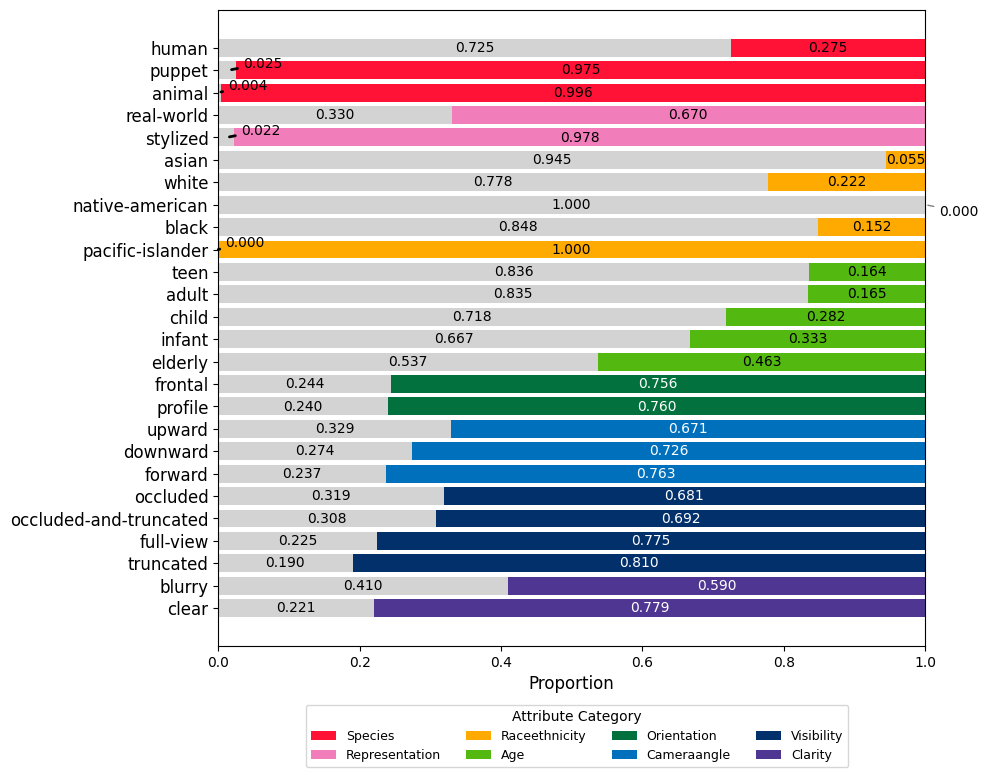

In [75]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Example color mapping for each major category
category_colors = {
    'species': '#FF1236',
    'representation': '#F17DBA',
    'raceethnicity': '#FFAA01',
    'age': '#53B810',
    'orientation': '#02713E',
    'cameraangle': '#0070BC',
    'visibility': '#02306B',
    'clarity': '#4F3692',
}

graphDict = cleanDict

# Extract and prepare data
labels = []
count_c = []
count_rest = []
bar_colors = []

for category, subcategories in graphDict.items():
    base_color = category_colors.get(category, 'steelblue')  # fallback to steelblue if not defined
    for subcat, val in subcategories.items():
        labels.append(subcat)
        c = val[3]
        count_c.append(c)
        count_rest.append(1 - c)
        bar_colors.append(base_color)

# Plot
fig, ax = plt.subplots(figsize=(10, 0.3 * len(labels)))
y_pos = range(len(labels))

# Stacked bars
bars1 = ax.barh(y_pos, count_rest, color="lightgray", label='Proportion of Recognized Instances',)
bars2 = ax.barh(y_pos, count_c, left=count_rest, color=bar_colors, label='Proportion of Missed Instances')

# Labels
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize = 12)
ax.invert_yaxis()
ax.tick_params(axis='x', labelsize=10)
ax.set_xlim(0, 1)
ax.set_xlabel("Proportion", fontsize = 12)
# ax.set_title("Proportion of Recognized vs Missed Instances for Each Attribute Value", fontsize = 20)
# Build legend handles for each category color
legend_handles = []
for category, color in category_colors.items():
    patch = Patch(facecolor=color, label=category.capitalize())
    legend_handles.append(patch)

# Add custom legend
ax.legend(
    handles=legend_handles,
    loc='lower right',
    bbox_to_anchor=(0.9, -0.2),  # adjust as needed
    fontsize=9,
    title="Attribute Category",
    title_fontsize=10,
    ncol=4,
)
# Annotate each section
# Get category list for each bar

bar_categories = []
for category, subcategories in graphDict.items():
    for _ in subcategories:
        bar_categories.append(category)

# Annotate each section with conditional color
for i, (c, r) in enumerate(zip(count_c, count_rest)):
    category = bar_categories[i]
    is_dark = category in ['orientation', 'cameraangle', 'visibility', 'clarity']
    text_color = 'white' if is_dark else 'black'

    # Annotate count_rest directly if big enough
    if r > 0.05:
        ax.text(r / 2, i, f"{r:.3f}", ha='center', va='center', fontsize=10, color='black')
    else:
        ax.annotate(f"{r:.3f}",
                    xy=(max(0, r - 0.01), i), 
                    xytext=(r + 0.01, i - 0.3),  # shift label outward
                    textcoords='data',
                    fontsize=10,
                    color='black',
                    arrowprops=dict(arrowstyle='-', color='black', lw=2),
                    ha='left', va='center')

    # Annotate count_c directly if big enough
    if c > 0.05:
        ax.text(r + c / 2, i, f"{c:.3f}", ha='center', va='center', fontsize=10, color=text_color)
    else:
        ax.annotate(f"{c:.3f}",
                    xy=(r + c, i),
                    xytext=(r + c + 0.02, i + 0.3),
                    textcoords='data',
                    fontsize=10,
                    color=text_color,
                    arrowprops=dict(arrowstyle='-', color='gray', lw=1),
                    ha='left', va='center')



plt.tight_layout()
plt.show()
